In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def distance(a,b) :
    return np.linalg.norm(a - b)

## random selection based on numpy

In [3]:
def randsamp(N,R,W):
    return np.asarray(R)[np.random.choice(len(R), N, p=W/W.sum())]

## more explicit form for the random selection

In [4]:
def select_random (N,W,R):
    # Calculate sum of all weights
    totw = sum(W)
    tt , landmarks = 0 , []
    for i in range (0,N):
        # Generate a random number between 0 and the total weight
        # of the unselected points
        tw,rand = 0 , (totw-tt)*np.random.uniform(0,1)
        for j in range (0 ,len(R)):
            # Make sure each landmark is only selected once
            if R[j] in landmarks : continue
            tw += W[ j ]
            if rand < tw:
                landmarks.append(R[j])
                tt += W[j]
                break
    return landmarks

## simple version of FPS algorithm. Terribly slow

In [5]:
def farthest_point_sampling(N,W,R):
    #Select the first landmark at random
    ll = select_random(1,W,R)
    #ll=R[0]
    landmarks = [ll[0]]
    for i in range(1,N):
        #The outer loop ensures that the new landmark is the
        #farthest landmark from the set of landmarks that have
        #been selected thus far .
        maxd = 0.0
        for rr in R:
            #The inner loop here finds the minimum distance
            #between data point rr and the setof landmarks that
            #have been selected thus far.
            mind = float ('Infinity')
            for ll  in landmarks : #landmark closest to the point rr
                D=distance(ll,rr)
                if D < mind: mind = D
            if mind>maxd : # biggest among distance between rr and its closest landmark
                maxd = mind
                tland = rr
        landmarks.append(tland)
    return landmarks

## more efficient implementation of FPS

In [6]:
def FPS(X, n=0, idx=None):
    """
        Does Farthest Point Selection on a set of points X
        Adapted from a routine by Michele Ceriotti
    """
    N = X.shape[0]

    # If desired number of points less than or equal to zero,
    # select all points
    if n <= 0:
        n = N

    # Initialize arrays to store distances and indices
    fps_idxs = np.zeros(n, dtype=np.int32)
    d = np.zeros(n)

    if idx is None:
        # Pick first point at random
        idx = np.random.randint(0, N)
    fps_idxs[0] = idx

    # Compute distance from all points to the first point
    d1 = np.linalg.norm(X - X[idx], axis=1)**2

    # Loop over the remaining points...
    for i in range(1, n):

        # Get maximum distance and corresponding point
        fps_idxs[i] = np.argmax(d1)
        d[i - 1] = np.amax(d1)

        # Compute distance from all points to the selected point
        d2 = np.linalg.norm(X - X[fps_idxs[i]], axis=1)**2

        # Set distances to minimum among the last two selected points
        d1 = np.minimum(d1, d2)

        if d1.max() == 0.0:
            print("Only {} FPS Possible".format(i))
            return fps_idxs[:i], d[:i]

    return X[fps_idxs]#, d

## Algorithm to determine voronoi polyedra and wheights

In [7]:
def voronoi_weights(L,R,W):
    weights = np.zeros(len(L))
    tpoints = np.zeros(len(R))
    # Loop over all random vectorsin data set
    for i,r in enumerate(R) :
        #Find closest landmark to ith random vector
        dis=np.linalg.norm(L - r, axis=1)
        mind=np.amin(dis)
        nearest=np.argmin(dis)
        
        #Add weight of ith random vector
        #to weight of closest landmark
        #weights[nearest] += W[i]
        
        weights[nearest]+=W[i]
        #Also add the ith random vector to the list of
        #random vectors that are assigned to this landmark
        tpoints[i]=nearest
    points=[]
    for i,v in enumerate(L):
        points.append(R[np.where(tpoints==i)])
    return weights, points

## "well tempered FPS" based on FPS() function defined above

In [8]:
def wtfps_landmarks_selection(g,N,W,R) :
    K = int(np.sqrt(len(R)*N))
    #Select K landmarks using FPS
    fps_l=FPS(R, n=K, idx=None)
    #Calculate voronoi weights of fps landmarks and assign each of
    #the input random vectors to its associated voronoi polyhedron
    fps_w , fps_p = voronoi_weights(fps_l,R,W)
    #Modify the weights. We assume here that the sum of all
    #the weights in W is equal to one
    #Create a list containing the indices of the voronoi polyhedra
    fps_i=np.asarray(list(range(K)))
    #Now actually select the final landmarks
    ilandmarks = randsamp(N,fps_i,fps_w**g)
    #select one random point for each ilandmark
    landmarks = [ randsamp(1,fps_p[i],np.ones(len(fps_p[i])))[0] for i in ilandmarks]
    #landmarks=fps_l[ilandmarks]
    
    return np.asarray(landmarks)

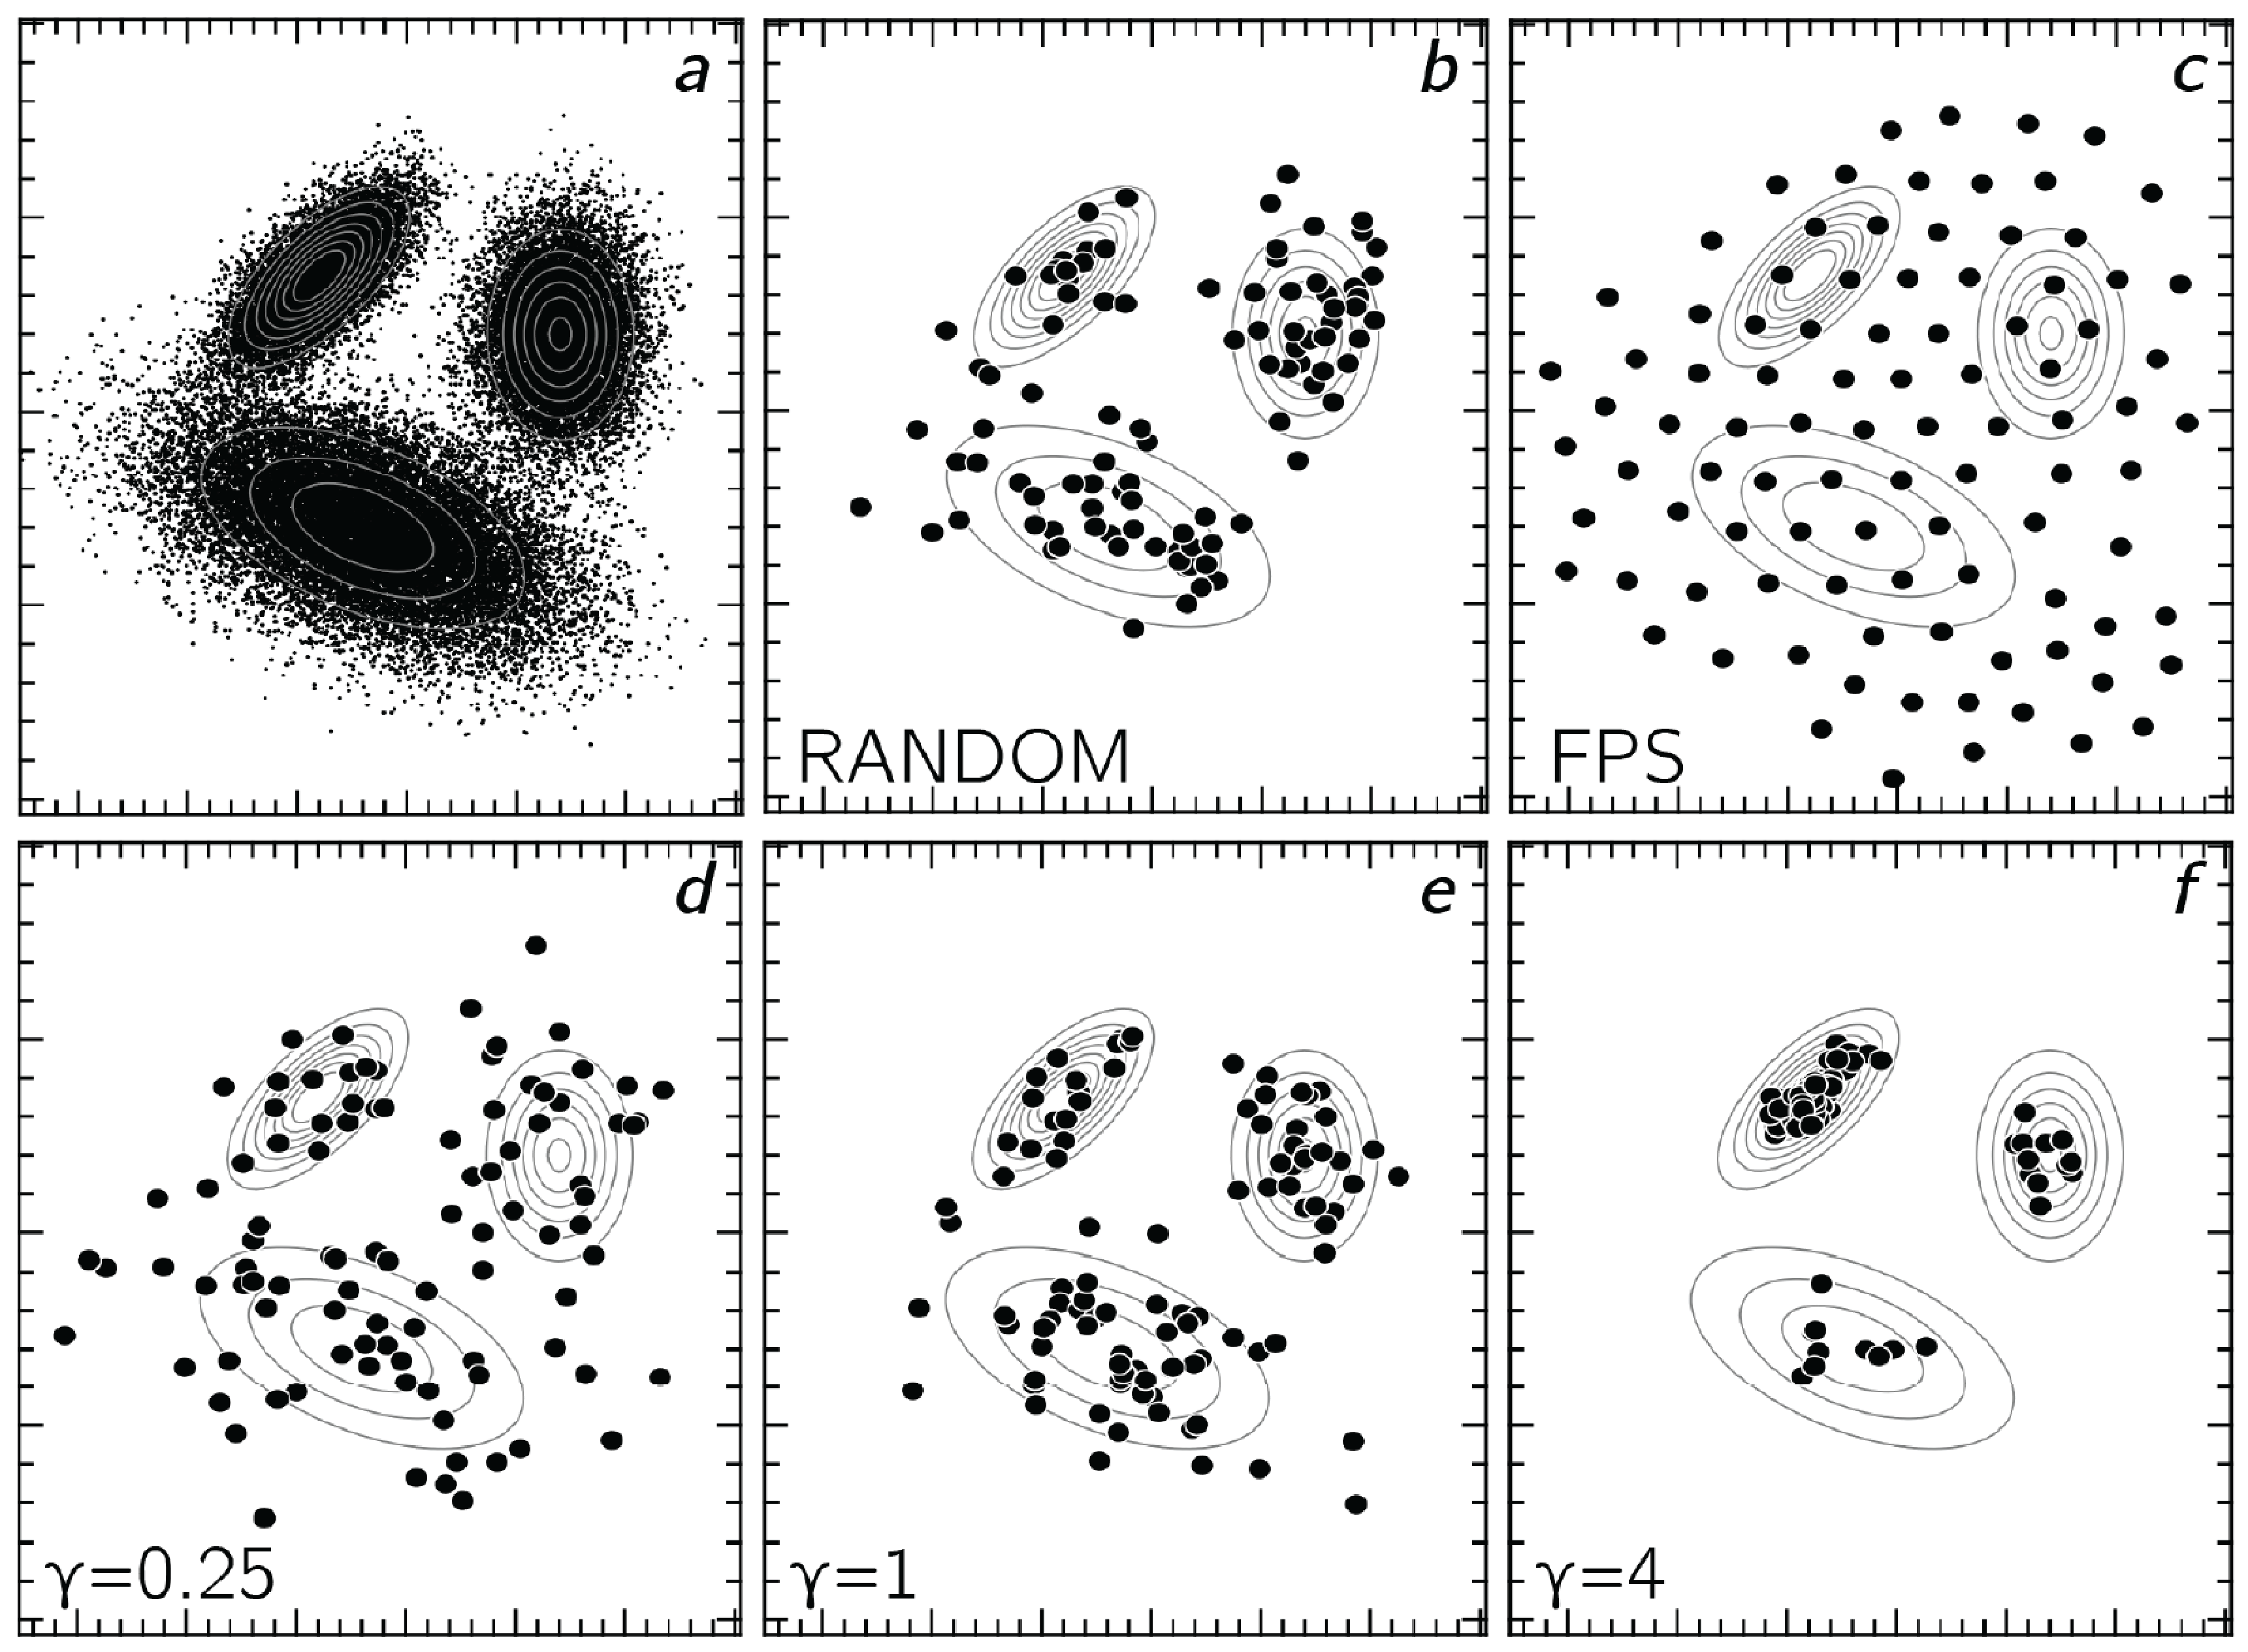

In [9]:
display.Image("./fps.png")

## creation of dataset "data" as superposition of three 2D gaussians (data1,data2,data3)

In [10]:
N1=5000
N2=5000
N3=5000
Ns=150

data1=np.random.normal([4,2], [1,0.7], size=[int(N1),2])
data2=np.random.normal([8.1,13], [2,1.5], size=[int(N2),2])
data3=np.random.normal([14,7], [1.5,0.5], size=[int(N3),2])
data = np.concatenate((data1, data2,data3), axis=0)
weights=np.ones(N1+N2+N3)/(N1+N2+N3)


## random selection of landmarks "lm"

In [11]:
lm=randsamp(Ns,data,weights)

## FPS selection of landmarks "lm_fp"

In [12]:
lm_fp=FPS(data, n=Ns, idx=None)

## improved FPS with three different values of $\gamma$ "lm_gfp1.."

In [13]:
lm_gfp1=wtfps_landmarks_selection(0.25,Ns,weights,data)
lm_gfp2=wtfps_landmarks_selection(1,Ns,weights,data)
lm_gfp3=wtfps_landmarks_selection(4,Ns,weights,data)

In [14]:
x1,y1 = data.T
x2,y2 = np.array(lm).T
x3,y3 = np.array(lm_fp).T
x4,y4 = np.array(lm_gfp1).T
x5,y5 = np.array(lm_gfp2).T
x6,y6 = np.array(lm_gfp3).T

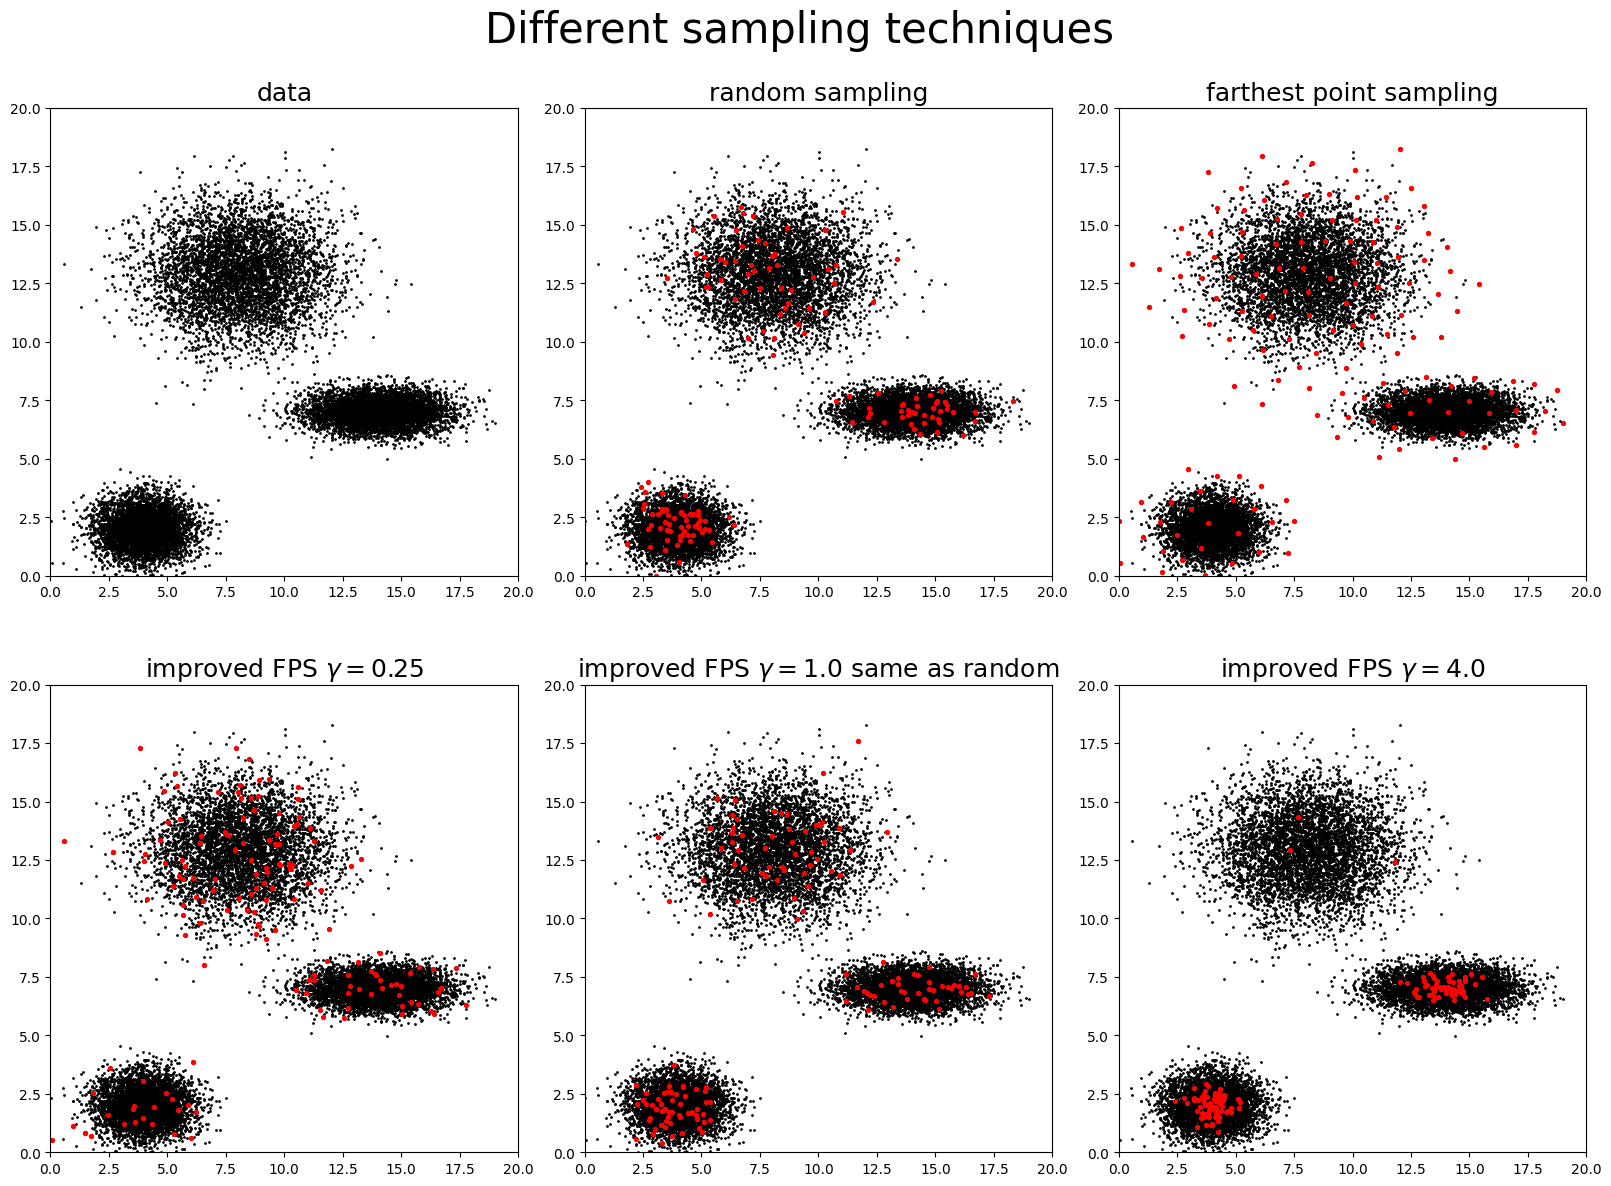

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,12), constrained_layout=True)
fig.suptitle('Different sampling techniques ', fontsize=30)
for i in range(0,2):
    for j in range (0,3):
        axs[i,j].set_xlim(0,20)
        axs[i,j].set_ylim(0,20)
ax = axs[0, 0]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.set_aspect('equal')
ax.set_title('data',fontsize=18)

ax = axs[0, 1]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.scatter(x2,y2,s=8,c='red',marker='o')
ax.set_aspect('equal')
ax.set_title('random sampling',fontsize=18)

ax = axs[0, 2]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.scatter(x3,y3,s=8,c='red',marker='o')
ax.set_aspect('equal')
ax.set_title('farthest point sampling',fontsize=18)

ax = axs[1, 0]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.scatter(x4,y4,s=8,c='red',marker='o')
ax.set_aspect('equal')
ax.set_title(r'improved FPS $\gamma=0.25$',fontsize=18)

ax = axs[1, 1]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.scatter(x5,y5,s=8,c='red',marker='o')
ax.set_aspect('equal')
ax.set_title(r'improved FPS $\gamma=1.0$ same as random',fontsize=18)

ax = axs[1, 2]
ax.scatter(x1,y1,s=1,c='black',marker='o')
ax.scatter(x6,y6,s=8,c='red',marker='o')
ax.set_aspect('equal')
ax.set_title(r'improved FPS $\gamma=4.0$',fontsize=18)
#plt.savefig("sampling.png",dpi=150)
plt.show()